# CPO Datascience

This program is intended for use by the Portland State University Campus Planning Office (CPO).  

In [2]:
#Import required packages
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt



In [10]:
def format_date(df_date):
    """
    Splits Meeting Times and Dates into datetime objects where applicable using regex.
    """
    df_date['Days'] = df_date['Meeting_Times'].str.extract('([^\s]+)', expand=True)
    df_date['Start_Date'] = df_date['Meeting_Dates'].str.extract('([^\s]+)', expand=True)
    df_date['Year'] = df_date['Term'].astype(str).str.slice(0,4)
    df_date['Quarter'] = df_date['Term'].astype(str).str.slice(5,6)
    df_date['Building'] = df_date['ROOM'].str.extract('([^\s]+)', expand=True)
    df_date['Start_Month'] = pd.to_datetime(df_date['Year'] + df_date['Start_Date'], format='%Y%b')
    df_date['End_Date'] = df_date['Meeting_Dates'].str.extract('(?<=-)(.*)(?= )', expand=True)
    #df_date['End_Month'] = pd.to_datetime(df_date['End_Date'], format='%b')
    df_date['Start_Time'] = df_date['Meeting_Times'].str.extract('(?<= )(.*)(?=-)', expand=True)
    df_date['Start_Time'] = pd.to_datetime(df_date['Start_Time'], format='%H%M')
    df_date['End_Time'] = df_date['Meeting_Times'].str.extract('((?<=-).*$)', expand=True)
    df_date['End_Time'] = pd.to_datetime(df_date['End_Time'], format='%H%M')
    df_date['Duration_Hr'] = ((df_date['End_Time'] - df_date['Start_Time']).dt.seconds)/3600
    df_date = df_date.set_index(pd.DatetimeIndex(df_date['Start_Month']))
    return df_date

def format_xlist(df_xl):
    """
    revises % capacity calculations by using Max Enrollment instead of room capacity.  
    """
    df_xl['Cap_Diff'] = np.where(df_xl['Xlst'] != '', 
                                   df_xl['Max_Enrl'].astype(int) - df_xl['Actual_Enrl'].astype(int), 
                                   df_xl['Room_Capacity'].astype(int) - df_xl['Actual_Enrl'].astype(int)) 
    df_xl = df_xl.loc[df_xl['Room_Capacity'].astype(int) < 999]

    return df_xl


def grouped_plot_graph(df_in):
    fig, ax = plt.subplots()
    grouped = df_in.groupby(['Year', 'Quarter'])
    for key, group in grouped:
        group.plot(ax=ax, kind='scatter', x='Start_Month', y='Cap_Diff', label=key)
    plt.show()
    
def plot_graph(x_vals, y_vals):
    """
    Plots the dataframe information.
    """
    x = range(len(x_vals))
    plt.figure(figsize=(20,10)) 
    N = 50
    colors = np.random.rand(N)
    sns.stripplot(x_vals, y_vals)
    plt.xticks(rotation=90)
    plt.scatter(x, y_vals, alpha=0.5, )
    plt.show()

def OLS_operations(y, X):
    #mod = smf.OLS('Cap_Diff ~ C(Dept)', data=df_data)
    mod = sm.OLS(np.asarray(y), X)
    res = mod.fit()
    print(res.summary())
    fig = plt.figure(figsize=(20,10))
    fig = sm.graphics.plot_partregress_grid(mod, fig=fig)
    plt.show()

def main():
    """
    Main program control flow.
    """
    #pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)
    df = pd.read_csv('data/PSU_master_classroom.csv')
    df = df.fillna('')

    df = format_date(df)
    # Avoid classes that only occur on a single day
    df = df.loc[df['Start_Date'] != df['End_Date']]
    df = df.loc[df['Online Instruct Method'] != 'Fully Online']
    #df = df.loc[df['Term'] == 201604]
    
    # Calculate number of days per week and treat Sunday condition
    df['Days_Per_Week'] = df['Days'].str.len()
    df['Room_Capacity'] = df['Room_Capacity'].apply(lambda x: x if (x != 'No Data Available') else 0)
    
    df_cl = format_xlist(df)
    
    #dates = pd.date_range('2013-01', '2013-12', freq='Q')
    #print(dates)
    
    
    #df_cl['Cap_Diff'].plot()
    dep_var = df_cl['Cap_Diff'] # Our dependent variable
    category = 'Dept'
    #string_var = df_cl['{0}'.format(category)] # Changeable test variables
    #string_var = np.asarray(sorted(string_var))
    #test_var = sm.tools.categorical(string_var, drop=True)
    test_var = df_cl['{0}'.format(category)]
    
    #df_cl = df_cl.groupby('Dept').mean()
    #df_cl['Cap_Diff'].plot()
    #plt.show()
    
    plot_graph(test_var, dep_var)
    #OLS_operations(dep_var, test_var)



DatetimeIndex(['2013-03-31', '2013-06-30', '2013-09-30'], dtype='datetime64[ns]', freq='Q-DEC')


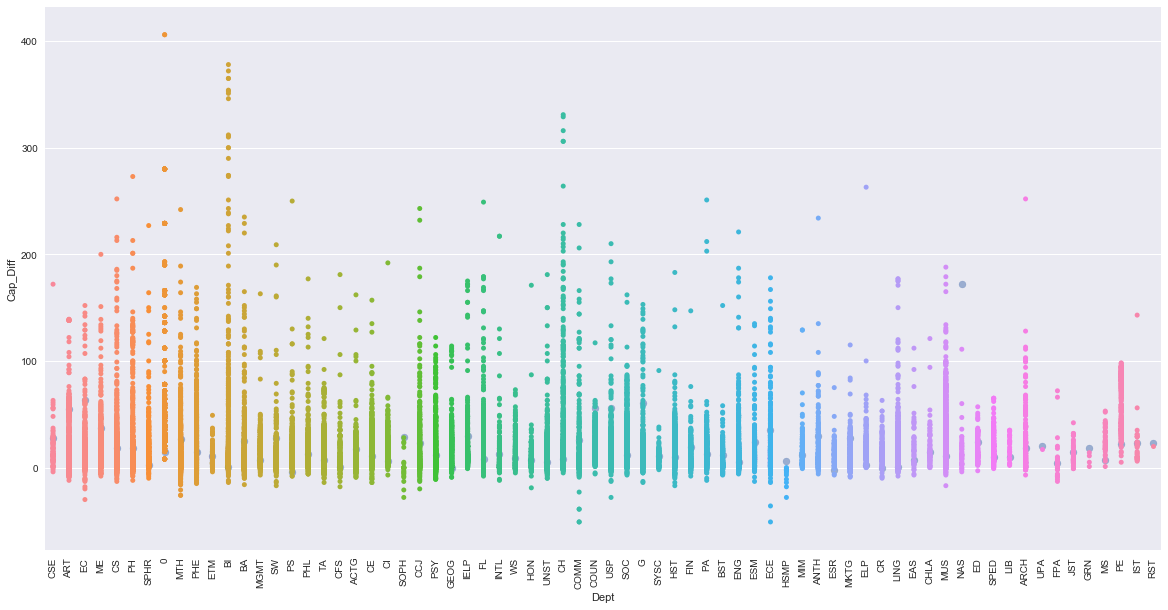

In [8]:
main()

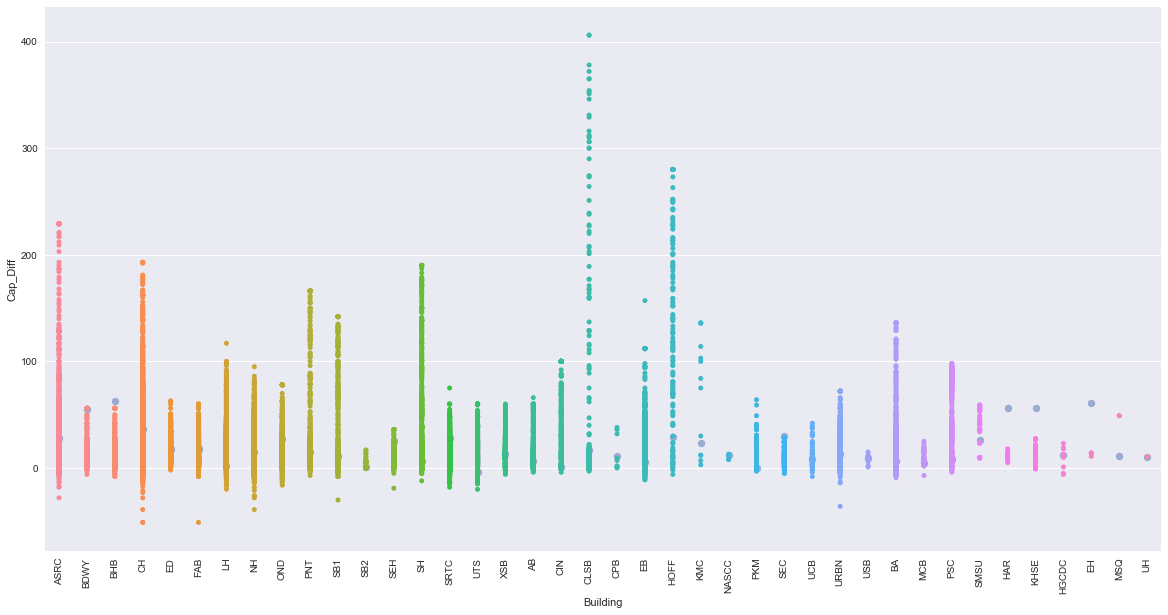

In [12]:
def main():
    pd.set_option('display.max_columns', None)
    df = pd.read_csv('data/PSU_master_classroom.csv')
    df = df.fillna('')
    df = format_date(df)
    # Avoid classes that only occur on a single day
    df = df.loc[df['Start_Date'] != df['End_Date']]
    df = df.loc[df['Online Instruct Method'] != 'Fully Online']
    df['Days_Per_Week'] = df['Days'].str.len()
    df['Room_Capacity'] = df['Room_Capacity'].apply(lambda x: x if (x != 'No Data Available') else 0)
    df_cl = format_xlist(df)
    dep_var = df_cl['Cap_Diff'] # Our dependent variable
    category = 'Building'
    test_var = df_cl['{0}'.format(category)]
    plot_graph(test_var, dep_var)
    
main()